# Titanic ML competition

## Outline
- [ 1 - Import Packages](#1)
- [ 2 - Data Load and Exploring](#2)
- [ 3 - Data Preprocessing](#3)
- [ 4 - XGBoost Without Hyperparameters Optimization](#4)
- [ 5 - XGBoost With Hyperparameters Optimization](#5)
- [ 6 - XGBoost Without Hyperparameters Optimization and "Name" Feature](#6)
- [ 7 - XGBoost With Hyperparameters Optimization and Without "Name" Feature](#7)

<a name="1"></a>
## 1 - Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_tree
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns

<a name="2"></a>
## 2 - Data Load and Exploring

In [2]:
# data load
test_data = 'test.csv'
train_data = 'train.csv'

train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# Looking for null values
print ("Train DF")
print (train_df.isnull().sum())
print ()
print ("Test DF")
print (test_df.isnull().sum())

Train DF
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test DF
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


<a name="3"></a>
## 3 - Data Preprocessing

In [5]:
# dropping 'PassengerId','Ticket' rows
train = train_df.drop(['PassengerId','Ticket'], axis = 1)
test = test_df.drop(['PassengerId','Ticket'], axis = 1)
#train = train_df.drop(['PassengerId','Name','Ticket'], axis = 1)
#test = test_df.drop(['PassengerId','Name','Ticket'], axis = 1)

# replacing null values with 0
train=train.replace(np.nan,0)
test=test.replace(np.nan,0)

# Looking for null values
print ("Train DF")
print (train.isnull().sum())
print ()
print ("Test DF")
print (test.isnull().sum())

Train DF
Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

Test DF
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64


In [6]:
# Exploring data types of dfs
print ("Train DF")
print (train.dtypes)
print ()
print ("Test DF")
print (test_df.dtypes)

Train DF
Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

Test DF
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [7]:
#unique cabin values
train['Cabin'].unique()

array([0, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       '

In [8]:
#keeping only cabin letter or 0 if null
train['Cabin'] = train['Cabin'].apply(lambda x : x[0] if x!=0 else 0)
test['Cabin'] = test['Cabin'].apply(lambda x : x[0] if x!=0 else 0)
train['Cabin'].unique()

array([0, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [9]:
# getting title from name
train['Name']=train['Name'].map(lambda x: re.findall(r'(?<=, )[^.]*',x)[0])
test['Name']=test['Name'].map(lambda x: re.findall(r'(?<=, )[^.]*',x)[0])
test['Name'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Name, dtype: int64

<AxesSubplot:ylabel='Survived'>

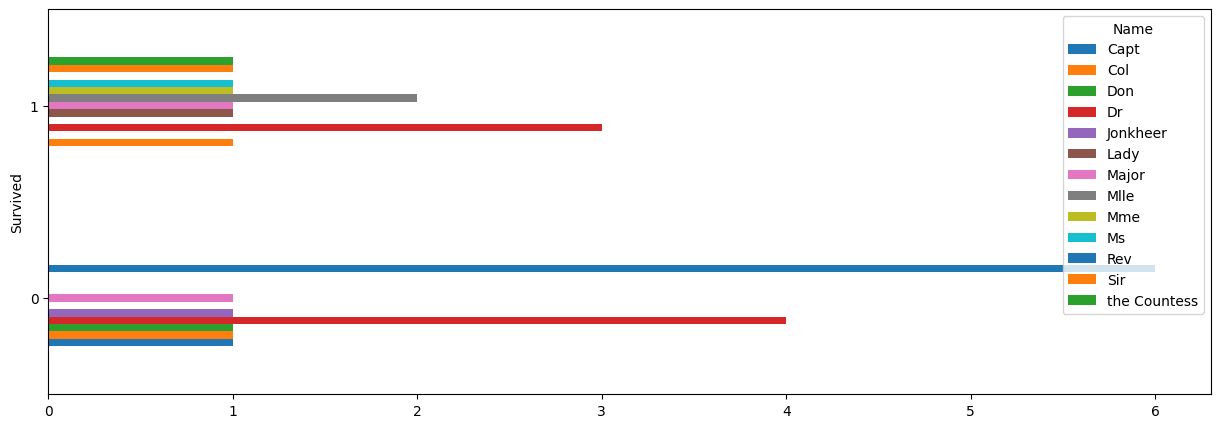

In [10]:
# checking if I should group smaller number of titles
plot_data = train[train['Name'].map(train['Name'].value_counts()) < 10]
plot_data[['Sex','Survived','Name']].groupby(['Survived','Name']).count().unstack().plot(kind='barh', y='Sex',figsize=(15, 5))

<AxesSubplot:xlabel='Age', ylabel='Survived'>

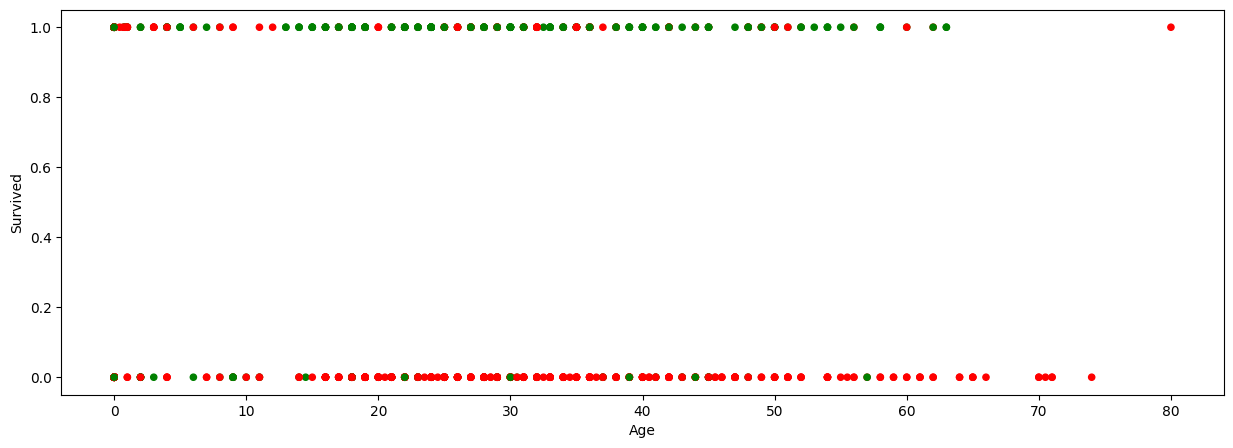

In [11]:
colors = {'male':'red', 'female':'green'}
train.plot.scatter(x='Age',y='Survived', c=train['Sex'].map(colors), figsize=(15, 5))

In [12]:
print ("Survived")
print (train[train.Survived == 1].describe())
print ()
print ("Did not survive")
print (train[train.Survived == 0].describe())

Survived
       Survived      Pclass         Age       SibSp       Parch        Fare
count     342.0  342.000000  342.000000  342.000000  342.000000  342.000000
mean        1.0    1.950292   24.034123    0.473684    0.464912   48.395408
std         0.0    0.863321   17.126720    0.708688    0.771712   66.596998
min         1.0    1.000000    0.000000    0.000000    0.000000    0.000000
25%         1.0    1.000000    7.250000    0.000000    0.000000   12.475000
50%         1.0    2.000000   25.000000    0.000000    0.000000   26.000000
75%         1.0    3.000000   35.000000    1.000000    1.000000   57.000000
max         1.0    3.000000   80.000000    4.000000    5.000000  512.329200

Did not survive
       Survived      Pclass         Age       SibSp       Parch        Fare
count     549.0  549.000000  549.000000  549.000000  549.000000  549.000000
mean        0.0    2.531876   23.653005    0.553734    0.329690   22.117887
std         0.0    0.735805   17.896150    1.288399    0.82316

In [13]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,Mr,male,22.0,1,0,7.2500,0,S
1,1,1,Mrs,female,38.0,1,0,71.2833,C,C
2,1,3,Miss,female,26.0,0,0,7.9250,0,S
3,1,1,Mrs,female,35.0,1,0,53.1000,C,S
4,0,3,Mr,male,35.0,0,0,8.0500,0,S


In [14]:
# one hot encoding
#one_hot_data = pd.get_dummies(shuffled_data, columns=['Pclass','Name','Sex','Cabin', 'Embarked'])
one_hot_data = pd.get_dummies(train, columns=['Pclass','Sex','Cabin', 'Embarked','Name'])

# Change all values into numbers between 0 and 1
normalized_data = (one_hot_data - one_hot_data.min()) / (one_hot_data.max() - one_hot_data.min())

# # Spliting x and y data 
X_normalized = normalized_data.drop(['Survived'], axis=1)
y = normalized_data[['Survived']]

In [15]:
X_normalized.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_0,...,Name_Master,Name_Miss,Name_Mlle,Name_Mme,Name_Mr,Name_Mrs,Name_Ms,Name_Rev,Name_Sir,Name_the Countess
0,0.2750,0.125,0.0,0.014151,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.4750,0.125,0.0,0.139136,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.3250,0.000,0.0,0.015469,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4375,0.125,0.0,0.103644,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.4375,0.000,0.0,0.015713,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


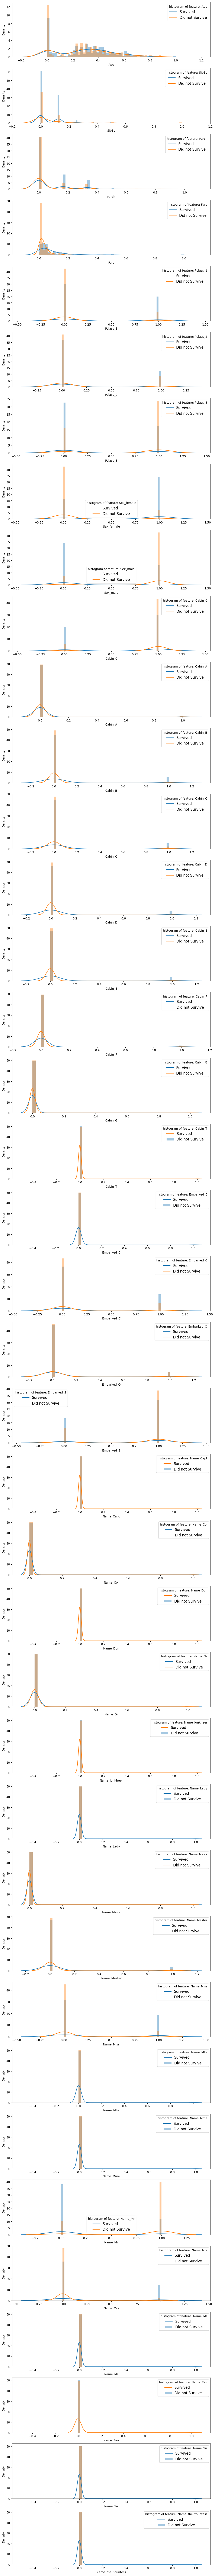

In [16]:
features = normalized_data.iloc[:,1:].columns
plt.figure(figsize=(12,39*4))
gs = gridspec.GridSpec(39, 1)
for i, cn in enumerate(normalized_data[features]):
    ax = plt.subplot(gs[i])
    try:
        sns.distplot(normalized_data[cn][normalized_data['Survived'] == 1], bins=50)
        sns.distplot(normalized_data[cn][normalized_data['Survived'] == 0], bins=50)
    except:
        print("An exception occurred in creating chart for {}".format(cn))

    #ax.set_xlabel('')
    plt.legend(labels=["Survived","Did not Survive"], title = 'histogram of feature: ' + str(cn), 
           fontsize = 'large', title_fontsize = "10")
    #ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [17]:
# Test data preprocessing
# one hot encoding
test_one_hot_data = pd.get_dummies(test, columns=['Pclass','Name','Sex','Cabin', 'Embarked'])

# Change all values into numbers between 0 and 1
X_test = (test_one_hot_data - test_one_hot_data.min()) / (test_one_hot_data.max() - test_one_hot_data.min())

X_test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Name_Col,Name_Dona,Name_Dr,...,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Embarked_C,Embarked_Q,Embarked_S
0,0.453947,0.000,0.000000,0.015282,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.618421,0.125,0.000000,0.013663,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.815789,0.000,0.000000,0.018909,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.355263,0.000,0.000000,0.016908,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.289474,0.125,0.111111,0.023984,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
X_normalized.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Cabin_0', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Embarked_0',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Name_Capt', 'Name_Col',
       'Name_Don', 'Name_Dr', 'Name_Jonkheer', 'Name_Lady', 'Name_Major',
       'Name_Master', 'Name_Miss', 'Name_Mlle', 'Name_Mme', 'Name_Mr',
       'Name_Mrs', 'Name_Ms', 'Name_Rev', 'Name_Sir', 'Name_the Countess'],
      dtype='object')

In [19]:
X_test.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Name_Col', 'Name_Dona', 'Name_Dr', 'Name_Master', 'Name_Miss',
       'Name_Mr', 'Name_Mrs', 'Name_Ms', 'Name_Rev', 'Sex_female', 'Sex_male',
       'Cabin_0', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [20]:
#renaming one of the test columns to match train dataset
X_test=X_test.rename(columns={"Name_Dona": "Name_Don"})
#Adding columns that are in training but not in test data
L = X_normalized.columns
for l in L:
    if l not in X_test:
        X_test[l]=0.0
X_test.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Name_Col', 'Name_Don', 'Name_Dr', 'Name_Master', 'Name_Miss',
       'Name_Mr', 'Name_Mrs', 'Name_Ms', 'Name_Rev', 'Sex_female', 'Sex_male',
       'Cabin_0', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Cabin_T', 'Embarked_0', 'Name_Capt', 'Name_Jonkheer', 'Name_Lady',
       'Name_Major', 'Name_Mlle', 'Name_Mme', 'Name_Sir', 'Name_the Countess'],
      dtype='object')

In [21]:
# sorting columns
X_test = X_test.reindex(sorted(X_test.columns), axis=1)
X_normalized = X_normalized.reindex(sorted(X_normalized.columns), axis=1)

In [53]:
X_train, X_cv, y_train, y_cv = train_test_split(X_normalized, y, random_state=42, stratify=y, test_size=0.2)

In [54]:
#checking if both datasets have equal proportion on survivors
print(y_train.sum()/len(y_train))
print()
print(y_cv.sum()/len(y_cv))

Survived    0.383427
dtype: float64

Survived    0.385475
dtype: float64


<a name="4"></a>
## 4 - XGBoost Without Hyperparameters Optimization

In [55]:
model=XGBClassifier(objective='binary:logistic',
                         seed=42)

model.fit(X_train, 
          y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [56]:
# make predictions for cv data
y_pred = model.predict(X_cv)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_cv, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.36%


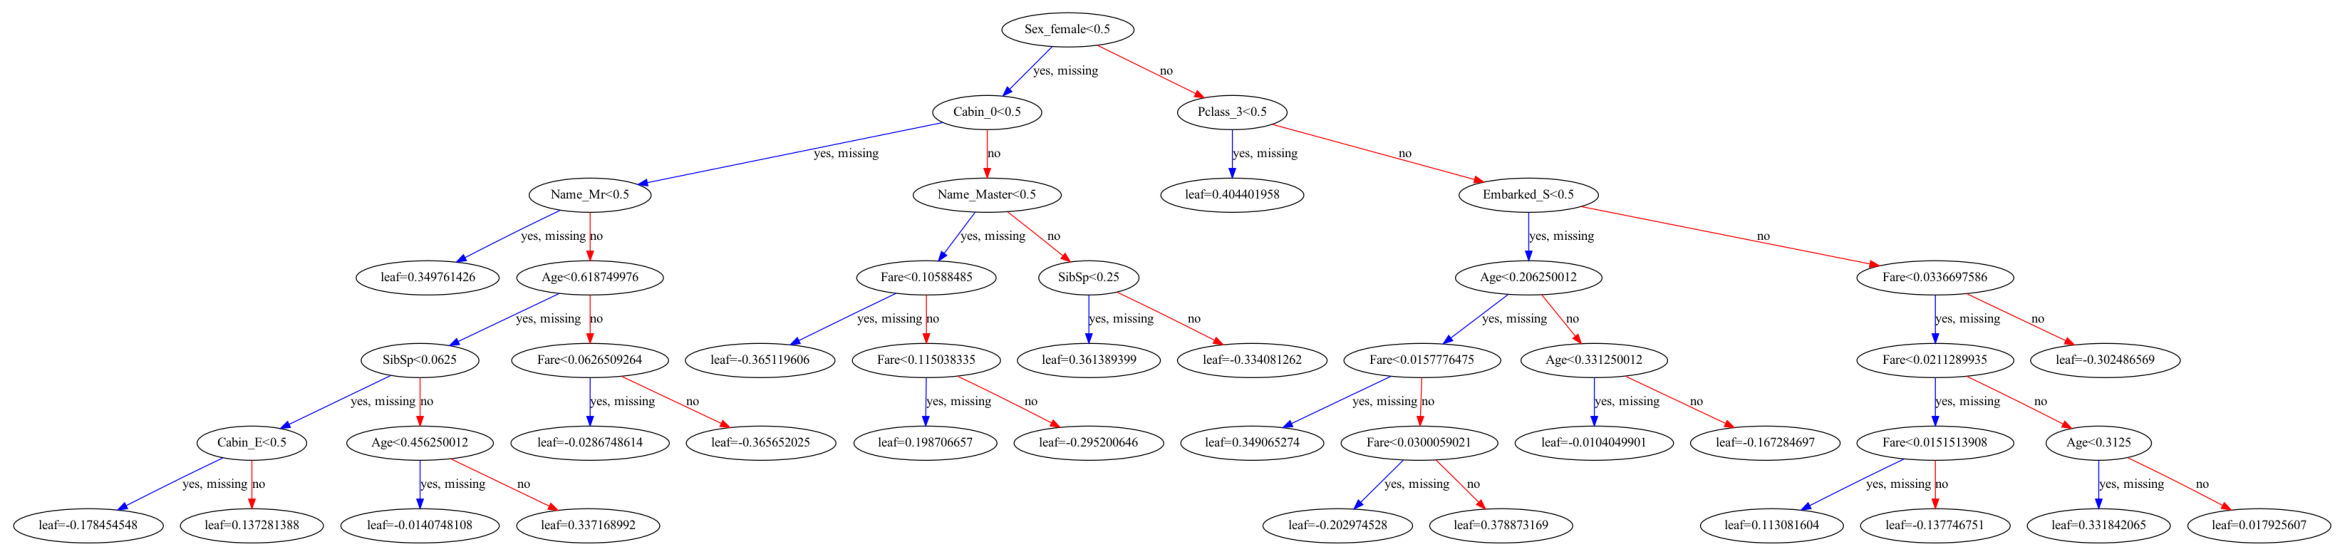

In [57]:
# tree plot
plot_tree(model, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(30, 15)

<AxesSubplot:>

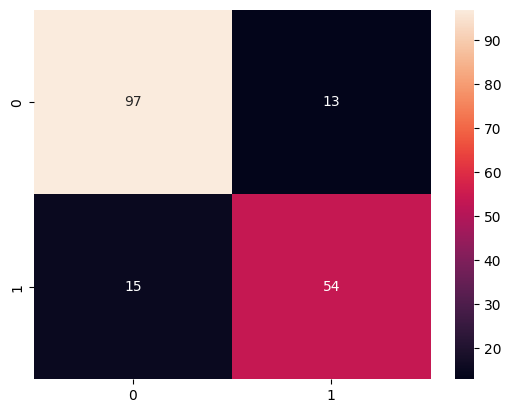

In [58]:
sns.heatmap(confusion_matrix(y_cv,predictions),annot=True)

<a name="5"></a>
## 5 - XGBoost With Hyperparameters Optimization

In [59]:
#round 1
param_grid = {
    'max_depth':[3,4,5,10],
    'learning_rate':[0.1,0.01,0.05, 0.03],
    'gamma':[0,0.25,1.0,0.5],
    'reg_lambda':[0,1.0,10.0, 0.5],
    'scale_pos_weight':[1,3,5, 10]
}
# best params 
#{'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 0.5, 'scale_pos_weight': 3}

In [60]:
#round 2
param_grid = {
    'max_depth':[15,20,25,10],
    'learning_rate':[0.1,0.2,0.15, 0.3],
    'gamma':[2.0,1.0,1.5, 2.5],
    'reg_lambda':[0,0.1,0.03, 0.05],
    'scale_pos_weight':[1,3,5, 4]
}
# best params 
#{'gamma': 2.5, 'learning_rate': 0.1, 'max_depth': 20, 'reg_lambda': 0.1, 'scale_pos_weight': 4}

In [76]:
#round 3
param_grid = {
    'max_depth':[15,20,17,10],
    'learning_rate':[0.1,0.2,0.25, 0.3],
    'gamma':[3.0,4.0,9.5, 2.5],
    'reg_lambda':[0,0.1,0.3, 0.5],
    'scale_pos_weight':[1,3,5, 4]
}
# best params 
#{'gamma': 3.0, 'learning_rate': 0.1, 'max_depth': 15, 'reg_lambda': 0.3, 'scale_pos_weight': 4}

In [ ]:
optimal_params = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                         missing=None, 
                                                         seed=42,
                                                         subsample=0.9,
                                                         colsample_bytree=0.5
                                                        ),
                                param_grid=param_grid,
                                scoring='roc_auc',
                                verbose=0,
                                n_jobs=10,
                                cv=3)


optimal_params.fit(X_train, 
                  y_train,
                  verbose=False,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_cv,y_cv)])
print(optimal_params.best_params_)

In [65]:
model=XGBClassifier(objective='binary:logistic',
                         seed=42,
                         subsample=0.9,
                         colsample_bytree=0.5,
                         gamma=3.0,
                         learning_rate=0.1,
                         max_depth=15,
                         reg_lambda=0.3,
                         scale_pos_weight=4
                        )

model.fit(X_train, 
          y_train,
          verbose=True,
          early_stopping_rounds=20,
          eval_metric='aucpr',
          eval_set=[(X_cv,y_cv)])

[0]	validation_0-aucpr:0.79608
[1]	validation_0-aucpr:0.80727
[2]	validation_0-aucpr:0.82929
[3]	validation_0-aucpr:0.82169
[4]	validation_0-aucpr:0.80116
[5]	validation_0-aucpr:0.81030
[6]	validation_0-aucpr:0.82104
[7]	validation_0-aucpr:0.81673
[8]	validation_0-aucpr:0.81094
[9]	validation_0-aucpr:0.80985
[10]	validation_0-aucpr:0.81456
[11]	validation_0-aucpr:0.81586
[12]	validation_0-aucpr:0.81199
[13]	validation_0-aucpr:0.81295
[14]	validation_0-aucpr:0.81090
[15]	validation_0-aucpr:0.81265
[16]	validation_0-aucpr:0.81320
[17]	validation_0-aucpr:0.81661
[18]	validation_0-aucpr:0.81876
[19]	validation_0-aucpr:0.82514
[20]	validation_0-aucpr:0.82712
[21]	validation_0-aucpr:0.82434


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0.3, ...)

In [66]:
# make predictions for cv data
y_pred = model.predict(X_cv)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_cv, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.30%


<AxesSubplot:>

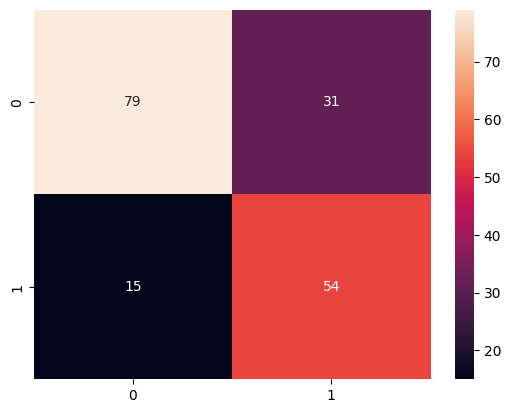

In [67]:
sns.heatmap(confusion_matrix(y_cv,predictions),annot=True)

<a name="6"></a>
## 6 - XGBoost Without Hyperparameters Optimization and "Name" Feature

In [68]:
X_train = X_train.drop(['Name_Capt', 'Name_Col', 'Name_Don', 'Name_Dr', 'Name_Jonkheer', 'Name_Lady', 'Name_Major', 'Name_Master', 'Name_Miss', 'Name_Mlle', 'Name_Mme', 'Name_Mr', 'Name_Mrs', 'Name_Ms', 'Name_Rev', 'Name_Sir', 'Name_the Countess'], axis=1)
X_cv = X_cv.drop(['Name_Capt','Name_Col','Name_Don','Name_Dr','Name_Jonkheer','Name_Lady','Name_Major','Name_Master','Name_Miss','Name_Mlle','Name_Mme','Name_Mr','Name_Mrs','Name_Ms','Name_Rev','Name_Sir','Name_the Countess'], axis=1)
print(X_train.columns)
print(X_cv.columns)

Index(['Age', 'Cabin_0', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Embarked_0', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Fare', 'Parch', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp'],
      dtype='object')
Index(['Age', 'Cabin_0', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Embarked_0', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Fare', 'Parch', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp'],
      dtype='object')


In [69]:
model=XGBClassifier(objective='binary:logistic',
                         seed=42)

model.fit(X_train, 
          y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [70]:
# make predictions for cv data
y_pred = model.predict(X_cv)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_cv, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.45%


<AxesSubplot:>

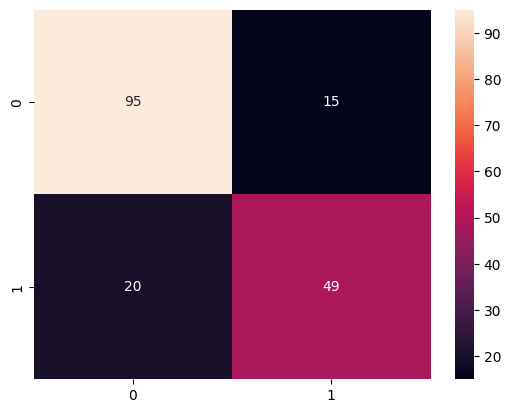

In [71]:
sns.heatmap(confusion_matrix(y_cv,predictions),annot=True)

<a name="7"></a>
## 7 - XGBoost With Hyperparameters Optimization and Without "Name" Feature

In [72]:
#round 1
param_grid = {
    'max_depth':[3,4,5,10],
    'learning_rate':[0.1,0.01,0.05, 0.03],
    'gamma':[0,0.25,1.0,0.5],
    'reg_lambda':[0,1.0,10.0, 0.5],
    'scale_pos_weight':[1,3,5, 10]
}
# best params 
#{'gamma': 0, 'learning_rate': 0.03, 'max_depth': 10, 'reg_lambda': 0, 'scale_pos_weight': 1}

In [73]:
#round 2
param_grid = {
    'max_depth':[25,20,15,10],
    'learning_rate':[0.1,0.01,0.05, 0.03],
    'gamma':[0,0.25,1.0,0.5],
    'reg_lambda':[0,01.0,0.3, 0.05],
    'scale_pos_weight':[1,3,5, 10]
}
# best params 
#{'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 25, 'reg_lambda': 0.05, 'scale_pos_weight': 1}

In [74]:
#round 3
param_grid = {
    'max_depth':[25,30,40,50],
    'learning_rate':[0.1,0.01,0.05, 0.03],
    'gamma':[0,0.25,1.0,0.5],
    'reg_lambda':[0,01.0,0.3, 0.05],
    'scale_pos_weight':[1,3,5, 10]
}
# best params 
#{'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 25, 'reg_lambda': 0.05, 'scale_pos_weight': 1}

In [ ]:
optimal_params = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                         missing=None, 
                                                         seed=42,
                                                         subsample=0.9,
                                                         colsample_bytree=0.5
                                                        ),
                                param_grid=param_grid,
                                scoring='roc_auc',
                                verbose=0,
                                n_jobs=10,
                                cv=3)


optimal_params.fit(X_train, 
                  y_train,
                  verbose=False,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_cv,y_cv)])
print(optimal_params.best_params_)

In [78]:
model=XGBClassifier(objective='binary:logistic',
                         seed=42,
                         subsample=0.8,
                         colsample_bytree=0.5,
                         gamma=0.25,
                         learning_rate=0.01,
                         max_depth=25,
                         reg_lambda=0.05,
                         scale_pos_weight=1
                        )
model.fit(X_train, 
          y_train,
          verbose=True,
          early_stopping_rounds=20,
          eval_metric='aucpr',
          eval_set=[(X_cv,y_cv)])

[0]	validation_0-aucpr:0.49590
[1]	validation_0-aucpr:0.74075
[2]	validation_0-aucpr:0.78814
[3]	validation_0-aucpr:0.79741
[4]	validation_0-aucpr:0.80909
[5]	validation_0-aucpr:0.81733
[6]	validation_0-aucpr:0.82287
[7]	validation_0-aucpr:0.81898
[8]	validation_0-aucpr:0.81596
[9]	validation_0-aucpr:0.81107
[10]	validation_0-aucpr:0.80975
[11]	validation_0-aucpr:0.81189
[12]	validation_0-aucpr:0.81241
[13]	validation_0-aucpr:0.81514
[14]	validation_0-aucpr:0.81530
[15]	validation_0-aucpr:0.81599
[16]	validation_0-aucpr:0.81158
[17]	validation_0-aucpr:0.81113
[18]	validation_0-aucpr:0.81043
[19]	validation_0-aucpr:0.81097
[20]	validation_0-aucpr:0.81725
[21]	validation_0-aucpr:0.81093
[22]	validation_0-aucpr:0.81180
[23]	validation_0-aucpr:0.80814
[24]	validation_0-aucpr:0.80990
[25]	validation_0-aucpr:0.81121


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.25, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0.05, ...)

In [79]:
# make predictions for cv data
y_pred = model.predict(X_cv)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_cv, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.01%


<AxesSubplot:>

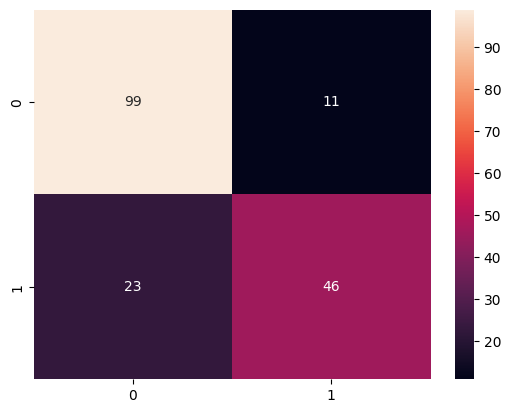

In [80]:
sns.heatmap(confusion_matrix(y_cv,predictions),annot=True)